## Import packages


In [1]:
import json
import glob
import os
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import pandas as pd


matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
plt.rcParams["figure.figsize"] = [20, 20]


### definition of many help funtions

In [2]:

def create_inp_out_folders(asetup, setup, over_folder):
    input_folder = os.path.join(over_folder,asetup)
    output_folder = os.path.join(over_folder,setup)
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
    return input_folder,output_folder
    
def prot_div(left, right):
    if right == 0:
        return 0
    else:
        return left / right


def if_func(condition, state1, state2):
    if condition:
        return state1
    else:
        return state2


def read_experiment_results(full_path):
    dir_name = full_path
    results = []
    it = 0
    try:
        while True:
            with open(dir_name + "iteration_" + str(it) + ".json") as json_file:
                data = json.load(json_file)
                if it % 1 == 0:
                    print(it)
                results.append(data)
            it += 1
    except:
        print("Finished reading ", full_path)
    return results


# extract number from file
def extract_number(f):
    s = re.findall("\d+$", f)
    return (int(s[0]) if s else -1, f)


"""Human sorting of files """
"""From https://nedbatchelder.com/blog/200712/human_sorting.html """


def tryint(s):
    """
    Return an int if possible, or `s` unchanged.
    """
    try:
        return int(s)
    except ValueError:
        return s


def alphanum_key(s):
    """
    Turn a string into a list of string and number chunks.

    >>> alphanum_key("z23a")
    ["z", 23, "a"]

    """
    return [tryint(c) for c in re.split("([0-9]+)", s)]


def human_sort(l):
    """
    Sort a list in the way that humans expect.
    """
    l.sort(key=alphanum_key)


def read_experiment_results_agnostic(full_path):
    results = []
    filenames = glob.glob(pathname="iteration_?*", root_dir=full_path)
    filenames_ordered = human_sort(filenames)
    try:
        for file in filenames:
            json_file = open(Path(os.path.join(full_path, file)))
            data = json.load(json_file)
            # if extract_number(file)[0] % 1 == 0:
                # print(file)
            results.append(data)
    except:
        print("Error in reading results ", full_path)
    return results
def load_results(folder, task, run_number):
    result_folder_path_from_root = os.path.join(folder, task)
    results_agnostic = []
    path = os.path.join(
        os.path.dirname(os.path.abspath(os.curdir)), result_folder_path_from_root
    )
    # print(path)

    for i in run_number:
        file_path = os.path.join(path, "run_" + str(i))
        results_agnostic.append(read_experiment_results_agnostic(file_path))
    results_agnostic.append({"task": task})
    return results_agnostic

In [3]:
# assuming folder with data for different tasks is in root directory
def load_results(folder, task, run_number):
    result_folder_path_from_root = os.path.join(folder, task)
    results_agnostic = []
    path = os.path.join(
        os.path.dirname(os.path.abspath(os.curdir)), result_folder_path_from_root
    )
    print(path)

    for i in run_number:
        file_path = os.path.join(path, "run_" + str(i))
        results_agnostic.append(read_experiment_results_agnostic(file_path))
        if len(results_agnostic[i - 1]) is not len(max(results_agnostic, key = len)):
            print("run ", i, "| gen: ", len(results_agnostic[i]))

    results_agnostic.append({"task": task})
    return results_agnostic


# Read data and convert to pandas

## Definitions

## slow convert

In [4]:
def convert_to_csv(task, asetup, setup, input_folder, output_folder, run_number):
    results_agnostic = load_results(folder=input_folder, task=task, run_number=run_number)

    df = pd.DataFrame(columns=["setup", "run", "iteration", "fitness", "smart_phenotype", "phenotype"])

    print(len(results_agnostic))
    run_number = 0
    for run in results_agnostic:
        if len(run) == 201:
            run_number += 1
            iteration_number = 0
            for iteration in run:
                iteration_number += 1
                for indiv in iteration:
                    row = pd.DataFrame({
                        "setup": setup, 
                        "run": int(run_number), 
                        "iteration": int(iteration_number), 
                        "fitness": float(indiv["fitness"]), 
                        "smart_phenotype": indiv["smart_phenotype"], 
                        "phenotype": indiv["phenotype"]}, 
                    index=[0])
                    df = pd.concat([df, row], ignore_index=True)
                    print(r'iteration: ', iteration_number)
        else:
            print("Skipping run ")
        print(len(df))

    df.to_csv(os.path.join(output_folder,f'{setup}_{task}.csv'), index=False)


## Faster populative method from [comment][link] on stackoverflow

[link]: https://stackoverflow.com/questions/17091769/python-pandas-fill-a-dataframe-row-by-row#:~:text=This%20is%20the,of%20index%20processing.

first making data into list of lists then converting to Panda

In [4]:
def fast_convert_to_csv(task, asetup, setup, input_folder, output_folder, run_number):
    results_agnostic = load_results(folder=input_folder, task=task, run_number=run_number)
    columns=["setup", "run", "iteration", "fitness", "smart_phenotype", "phenotype"]
    data = []

    for run_index, run in enumerate(results_agnostic):
            
            if type(run) is dict: 
                '''avoid the last elemtns of results_agnostic where task is specified in a dictionary'''
                continue
            
            if len(run) is not max(len(results_agnostic)):
                print(r'run: ', run_index, f"| gens: ", len(run))

            for iteration_index, iteration in enumerate(run):
                for ind_index, indiv in enumerate(iteration):
                  
                    try:
                        '''The order in which elements are in the list need to correspond to  columns => 
                        columns=["setup", "run", "iteration", "fitness", "smart_phenotype", "phenotype"]'''                        
                        ind_data = [setup,  run_index, iteration_index, indiv["fitness"], indiv["smart_phenotype"], indiv["phenotype"]]
                    except:
                        print("An exception occurred")
                        continue
                    data.append(ind_data)
    
    df = pd.DataFrame(data, columns=columns)

    df.to_csv(os.path.join(output_folder,f'{setup}_{task}.csv'), index=False)


## get evalutaions

In [10]:
def get_evaluations(df, filter=None):
    total_evaluations = 0.0
    numbers_of_runs = len(df["run"].unique())
    evaluations = np.zeros((numbers_of_runs, 201))
    df = df[filter]
    run_ix = 0
    for run in df["run"].unique():
        df_groupby_run = df[df["run"] == run].groupby("smart_phenotype")

        run_unique_behaviors = len(df_groupby_run.count())
        best_fitness = df[df["run"] == run]["fitness"].min()
        total_evaluations += run_unique_behaviors
        evaluations_per_iteration = df_groupby_run.first().groupby("iteration").count()
        for ix, row in evaluations_per_iteration.iterrows():
            count = row["fitness"] #any column will do
            evaluations[run_ix][ix - 1] += count
        run_ix += 1
    print(f"Average evaluations per run: {total_evaluations / numbers_of_runs} ({numbers_of_runs})")

    return evaluations



## Call

In [5]:
run_number = range(1, 31)

task = "fmni"
asetup = "many_runs"
setup = "FM"
input_folder, output_folder = create_inp_out_folders(asetup, setup, "many_results")

fast_convert_to_csv(task, asetup, setup, input_folder, output_folder, run_number)


c:\Users\p288427\Github\autolr\many_results\many_runs\fmni


IndexError: list index out of range

In [ ]:

asetup = "many_runs_new_crossover"
setup = "FMX"
input_folder, output_folder = create_inp_out_folders(asetup, setup, "many_results")

fast_convert_to_csv(task, asetup, setup, input_folder, output_folder, run_number)

asetup = "many_runs_no_crossover"
setup = "OM"
input_folder, output_folder = create_inp_out_folders(asetup, setup, "many_results")


fast_convert_to_csv(task, asetup, setup, input_folder, output_folder, run_number)


asetup = "many_runs_old_mut"
setup = "OMX"
input_folder, output_folder = create_inp_out_folders(asetup, setup, "many_results")


fast_convert_to_csv(task, asetup, setup, input_folder, output_folder, run_number)


In [ ]:
run_number = range(1, 31)

task = "fmni"
asetup = "many_runs"
setup = "FM"
input_folder, output_folder = create_inp_out_folders(asetup, setup, "many_results")

fast_convert_to_csv(task, asetup, setup, input_folder, output_folder, run_number)

asetup = "many_runs_new_crossover"
setup = "FMX"
input_folder, output_folder = create_inp_out_folders(asetup, setup, "many_results")

fast_convert_to_csv(task, asetup, setup, input_folder, output_folder, run_number)

asetup = "many_runs_no_crossover"
setup = "OM"
input_folder, output_folder = create_inp_out_folders(asetup, setup, "many_results")


fast_convert_to_csv(task, asetup, setup, input_folder, output_folder, run_number)


asetup = "many_runs_old_mut"
setup = "OMX"
input_folder, output_folder = create_inp_out_folders(asetup, setup, "many_results")


fast_convert_to_csv(task, asetup, setup, input_folder, output_folder, run_number)


## Read data into csv files

In [ ]:
task = "fmni"
asetup = "many_runs"
setup = "FM"
input_folder, output_folder = create_inp_out_folders(asetup, setup, "many_results")
df_fm = pd.read_csv(os.path.join(output_folder,r"FM_fmni.csv"))

asetup = "many_runs_new_crossover"
setup = "FMX"
input_folder, output_folder = create_inp_out_folders(asetup, setup, "many_results")
df_fmx = pd.read_csv(os.path.join(output_folder,r"FMX_fmni.csv"))

asetup = "many_runs_no_crossover"
setup = "OM"
input_folder, output_folder = create_inp_out_folders(asetup, setup, "many_results")
df_om = pd.read_csv(os.path.join(output_folder,r"OM_fmni.csv"))


asetup = "many_runs_old_mut"
setup = "OMX"
input_folder, output_folder = create_inp_out_folders(asetup, setup, "many_results")
df_omx = pd.read_csv(os.path.join(output_folder,r"OMX_fmni.csv"))

## Plots

### Evaluations over time

FM
Average evaluations per run: 2136.9 (30)
FMX
Average evaluations per run: 2915.133333333333 (30)
OM
Average evaluations per run: 2978.366666666667 (30)
OMX
Average evaluations per run: 10933.0 (30)


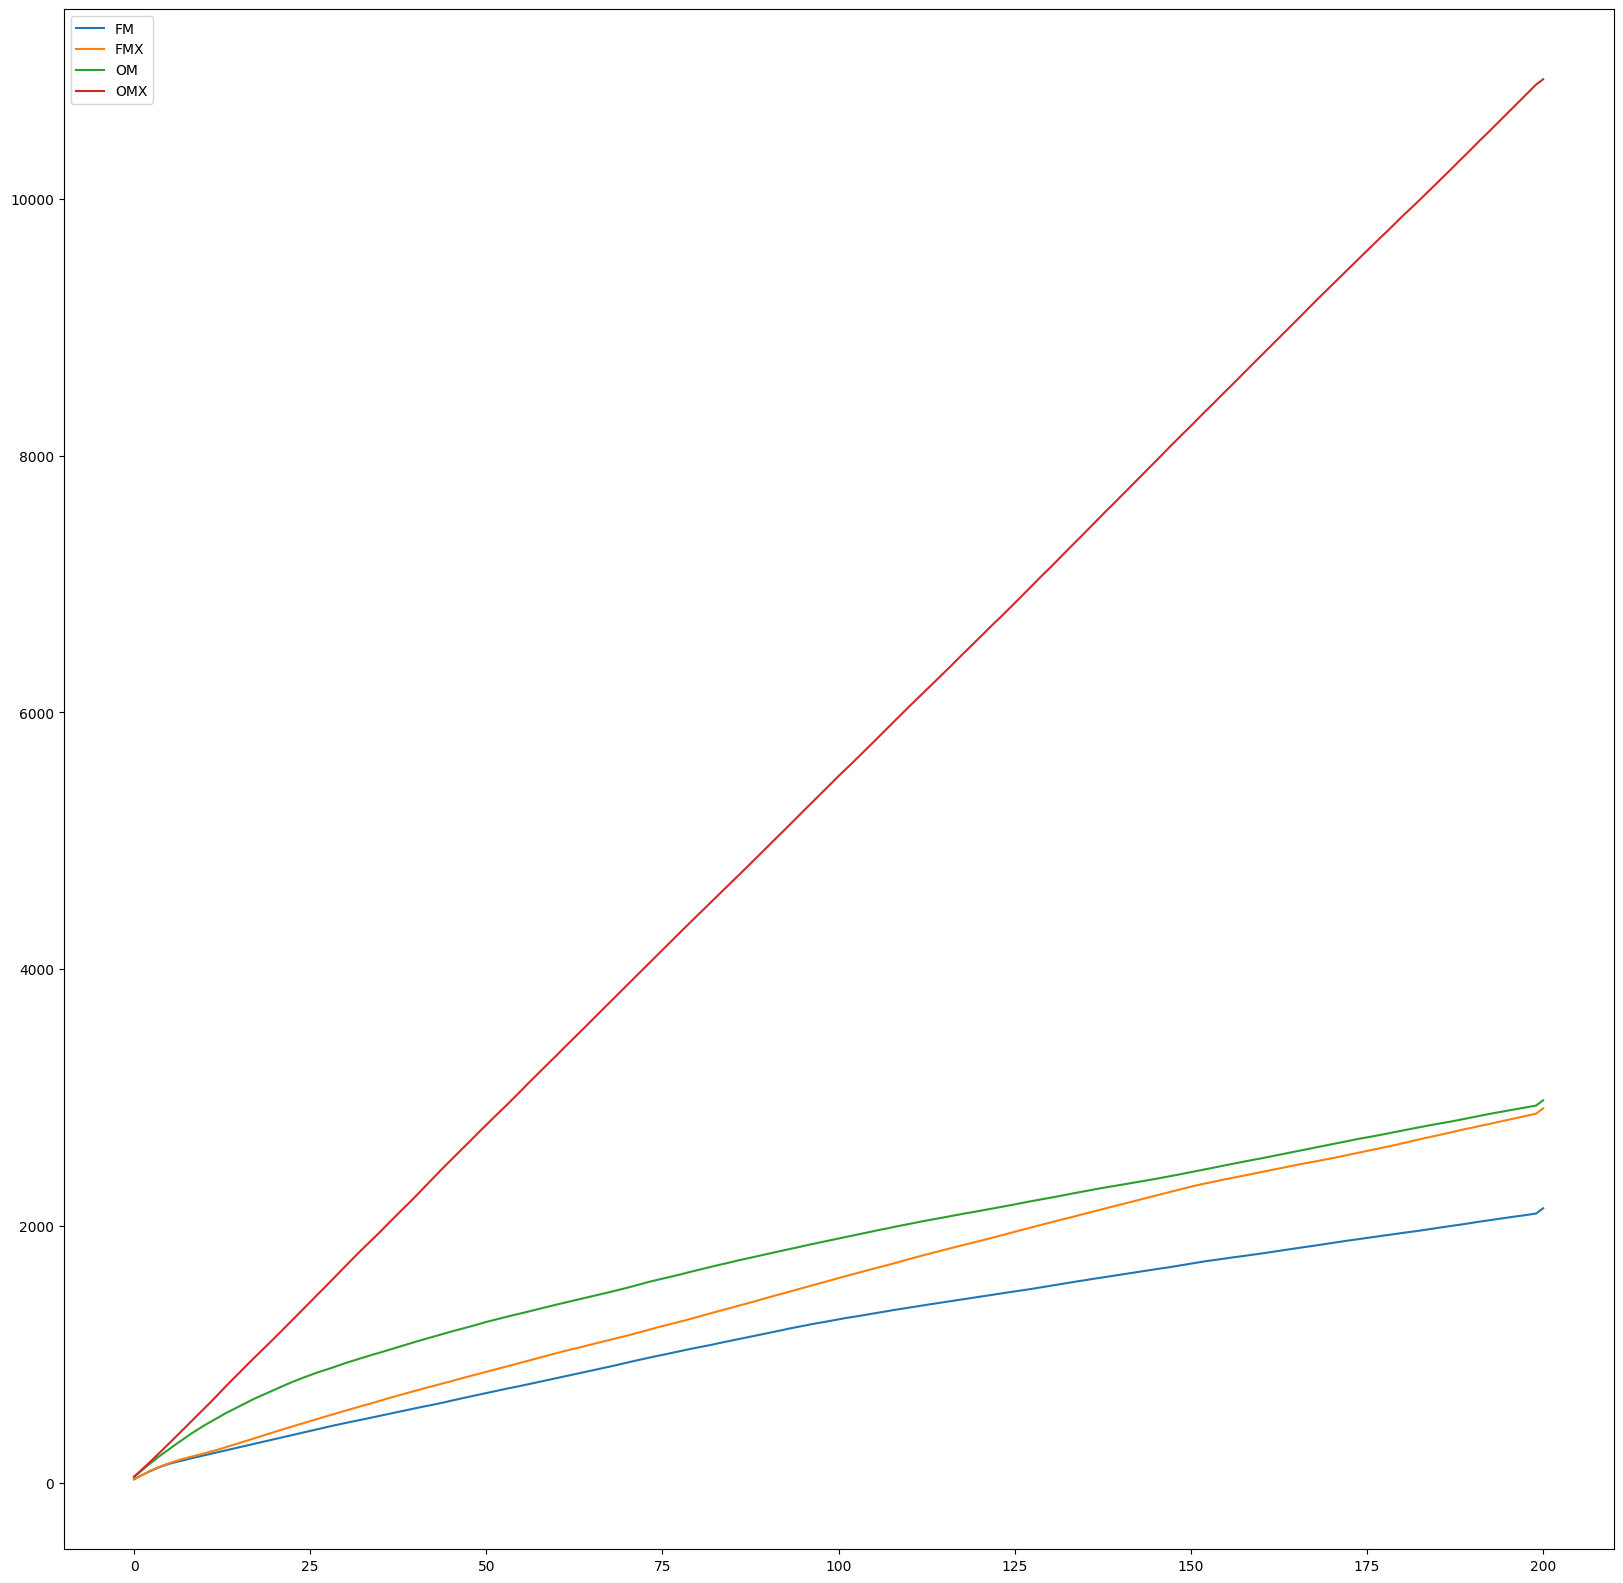

In [ ]:
print("FM")
fm_evaluations = get_evaluations(df_fm, df_fm['smart_phenotype'].apply(lambda x: "grad" in x))
print("FMX")
fmx_evaluations = get_evaluations(df_fmx, df_fmx['smart_phenotype'].apply(lambda x: "grad" in x))
print("OM")
om_evaluations = get_evaluations(df_om, df_om['smart_phenotype'].apply(lambda x: "grad" in x))
print("OMX")
omx_evaluations = get_evaluations(df_omx, df_omx['smart_phenotype'].apply(lambda x: "grad" in x))
plt.plot(np.arange(201), np.cumsum(np.average(fm_evaluations, axis=0), axis=0), label="FM")
plt.plot(np.arange(201), np.cumsum(np.average(fmx_evaluations, axis=0), axis=0), label="FMX")
plt.plot(np.arange(201), np.cumsum(np.average(om_evaluations, axis=0), axis=0), label="OM")
plt.plot(np.arange(201), np.cumsum(np.average(omx_evaluations, axis=0), axis=0), label="OMX")
plt.legend()
plt.show()

exclude those who do not even have grad

In [ ]:
df_fm['smart_phenotype'].apply(lambda x: "grad" in x)
i = 0
for x in df_fm['smart_phenotype']:
    if 'grad' not in x:
        pass
        #print(i ,x)
    i+=1
df_fm['smart_phenotype'].apply(lambda x: "grad" in x)


0         True
1         True
2         True
3         True
4         True
          ... 
299495    True
299496    True
299497    True
299498    True
299499    True
Name: smart_phenotype, Length: 299500, dtype: bool

treshild of fit = 0.1

FM
Average evaluations per run: 1523.7333333333333 (30)
FMX
Average evaluations per run: 1389.4 (15)
OM
Average evaluations per run: 2393.076923076923 (26)
OMX
Average evaluations per run: 6515.517241379311 (29)


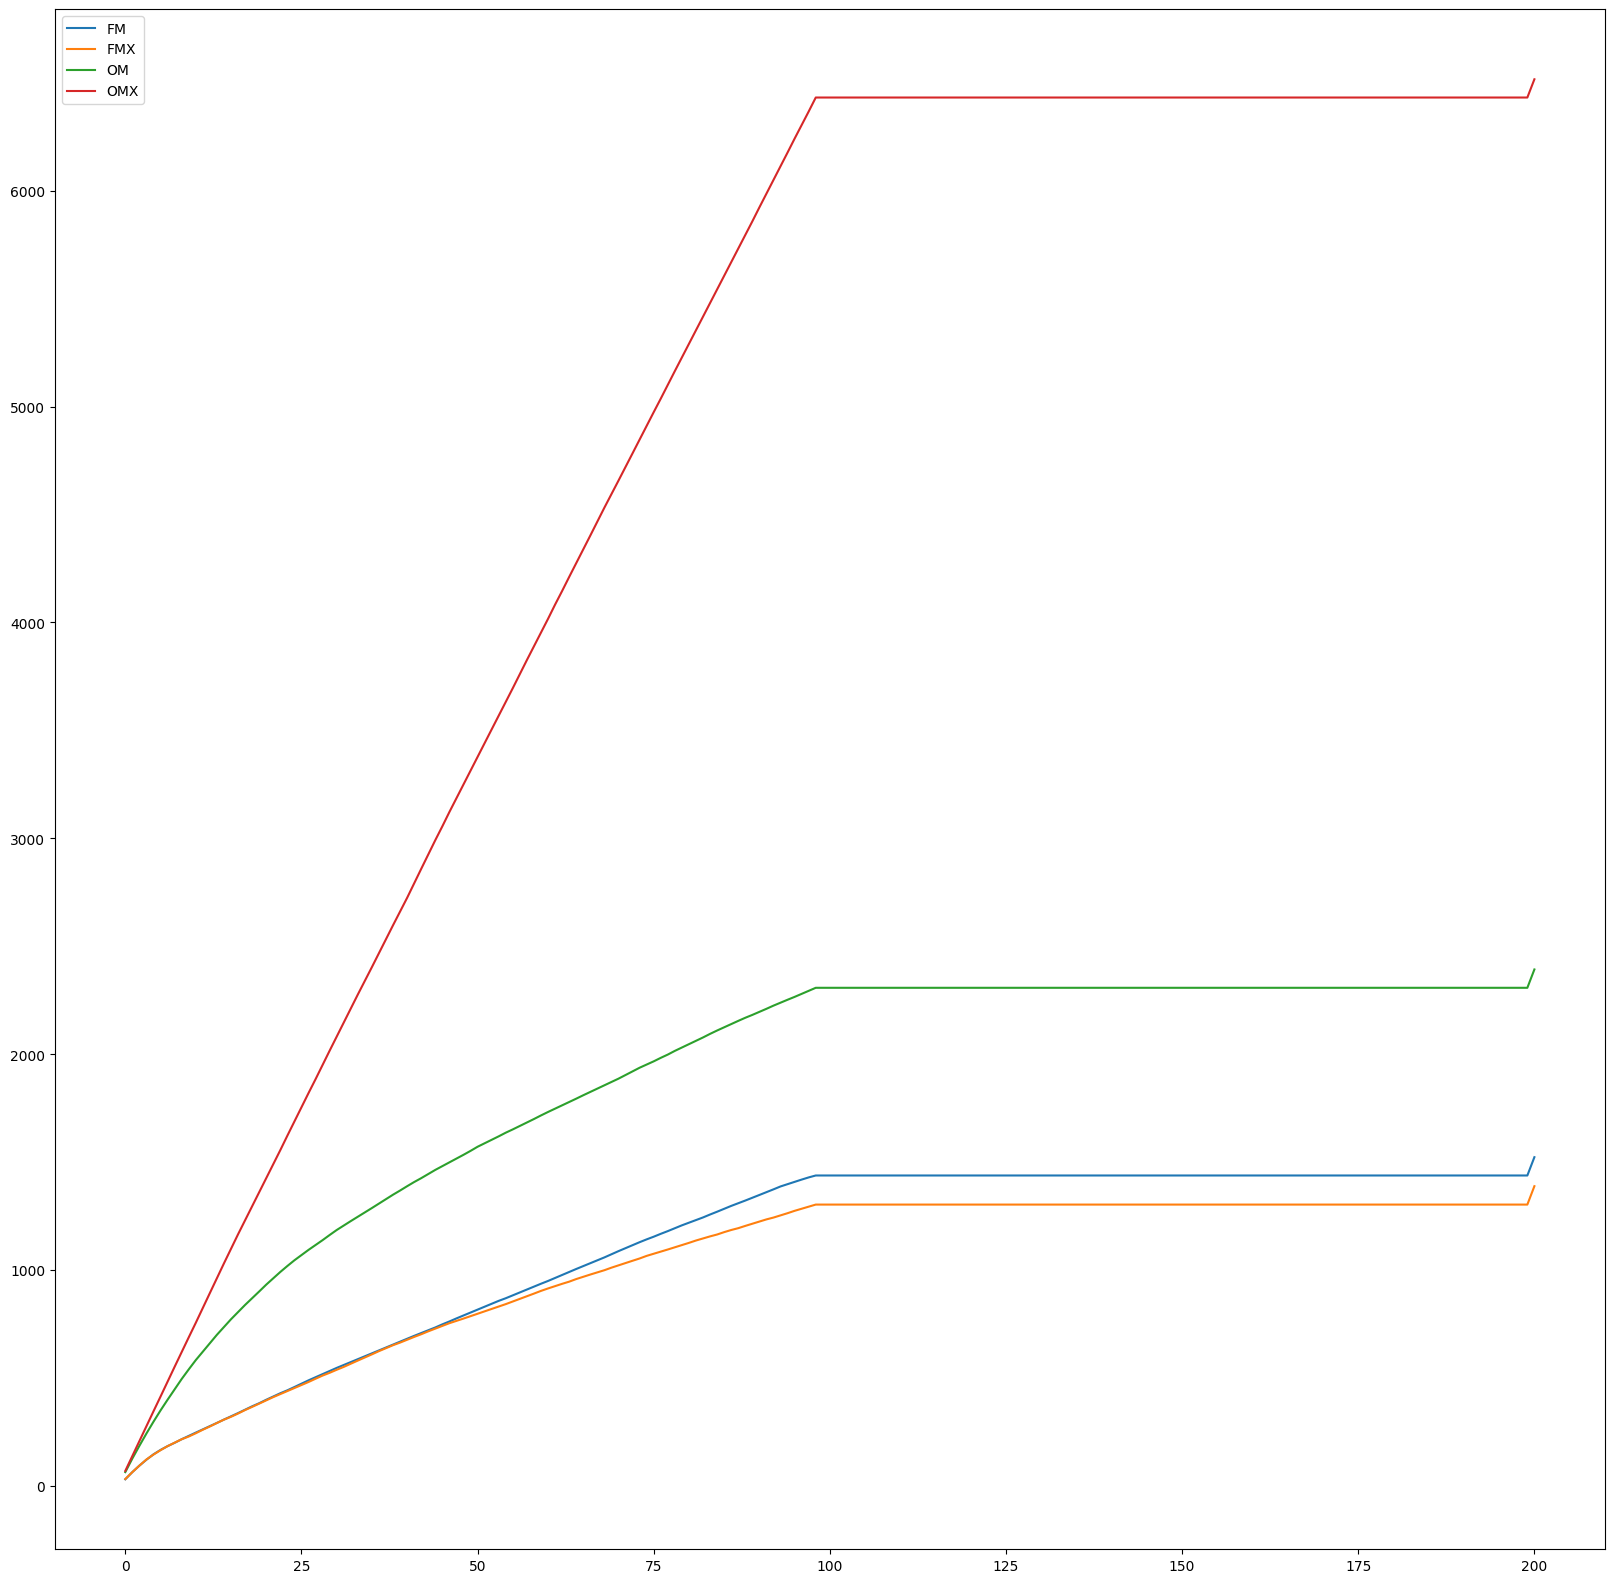

In [ ]:
threshold = 1.0

print("FM")
fm_uniques = get_evaluations(df_fm, df_fm['fitness'] < threshold)
print("FMX")
fmx_uniques = get_evaluations(df_fmx, df_fmx['fitness'] < threshold)
print("OM")
om_uniques = get_evaluations(df_om, df_om['fitness'] < threshold)
print("OMX")
omx_uniques = get_evaluations(df_omx, df_omx['fitness'] < threshold)
plt.plot(np.arange(201), np.cumsum(np.average(fm_uniques, axis=0), axis=0), label="FM")
plt.plot(np.arange(201), np.cumsum(np.average(fmx_uniques, axis=0), axis=0), label="FMX")
plt.plot(np.arange(201), np.cumsum(np.average(om_uniques, axis=0), axis=0), label="OM")
plt.plot(np.arange(201), np.cumsum(np.average(omx_uniques, axis=0), axis=0), label="OMX")
plt.legend()
plt.show()

treshold = -0.2

FM
Average evaluations per run: 213.06666666666666 (30)
FMX
Average evaluations per run: 246.4 (15)
OM
Average evaluations per run: 80.42307692307692 (26)
OMX
Average evaluations per run: 68.48275862068965 (29)


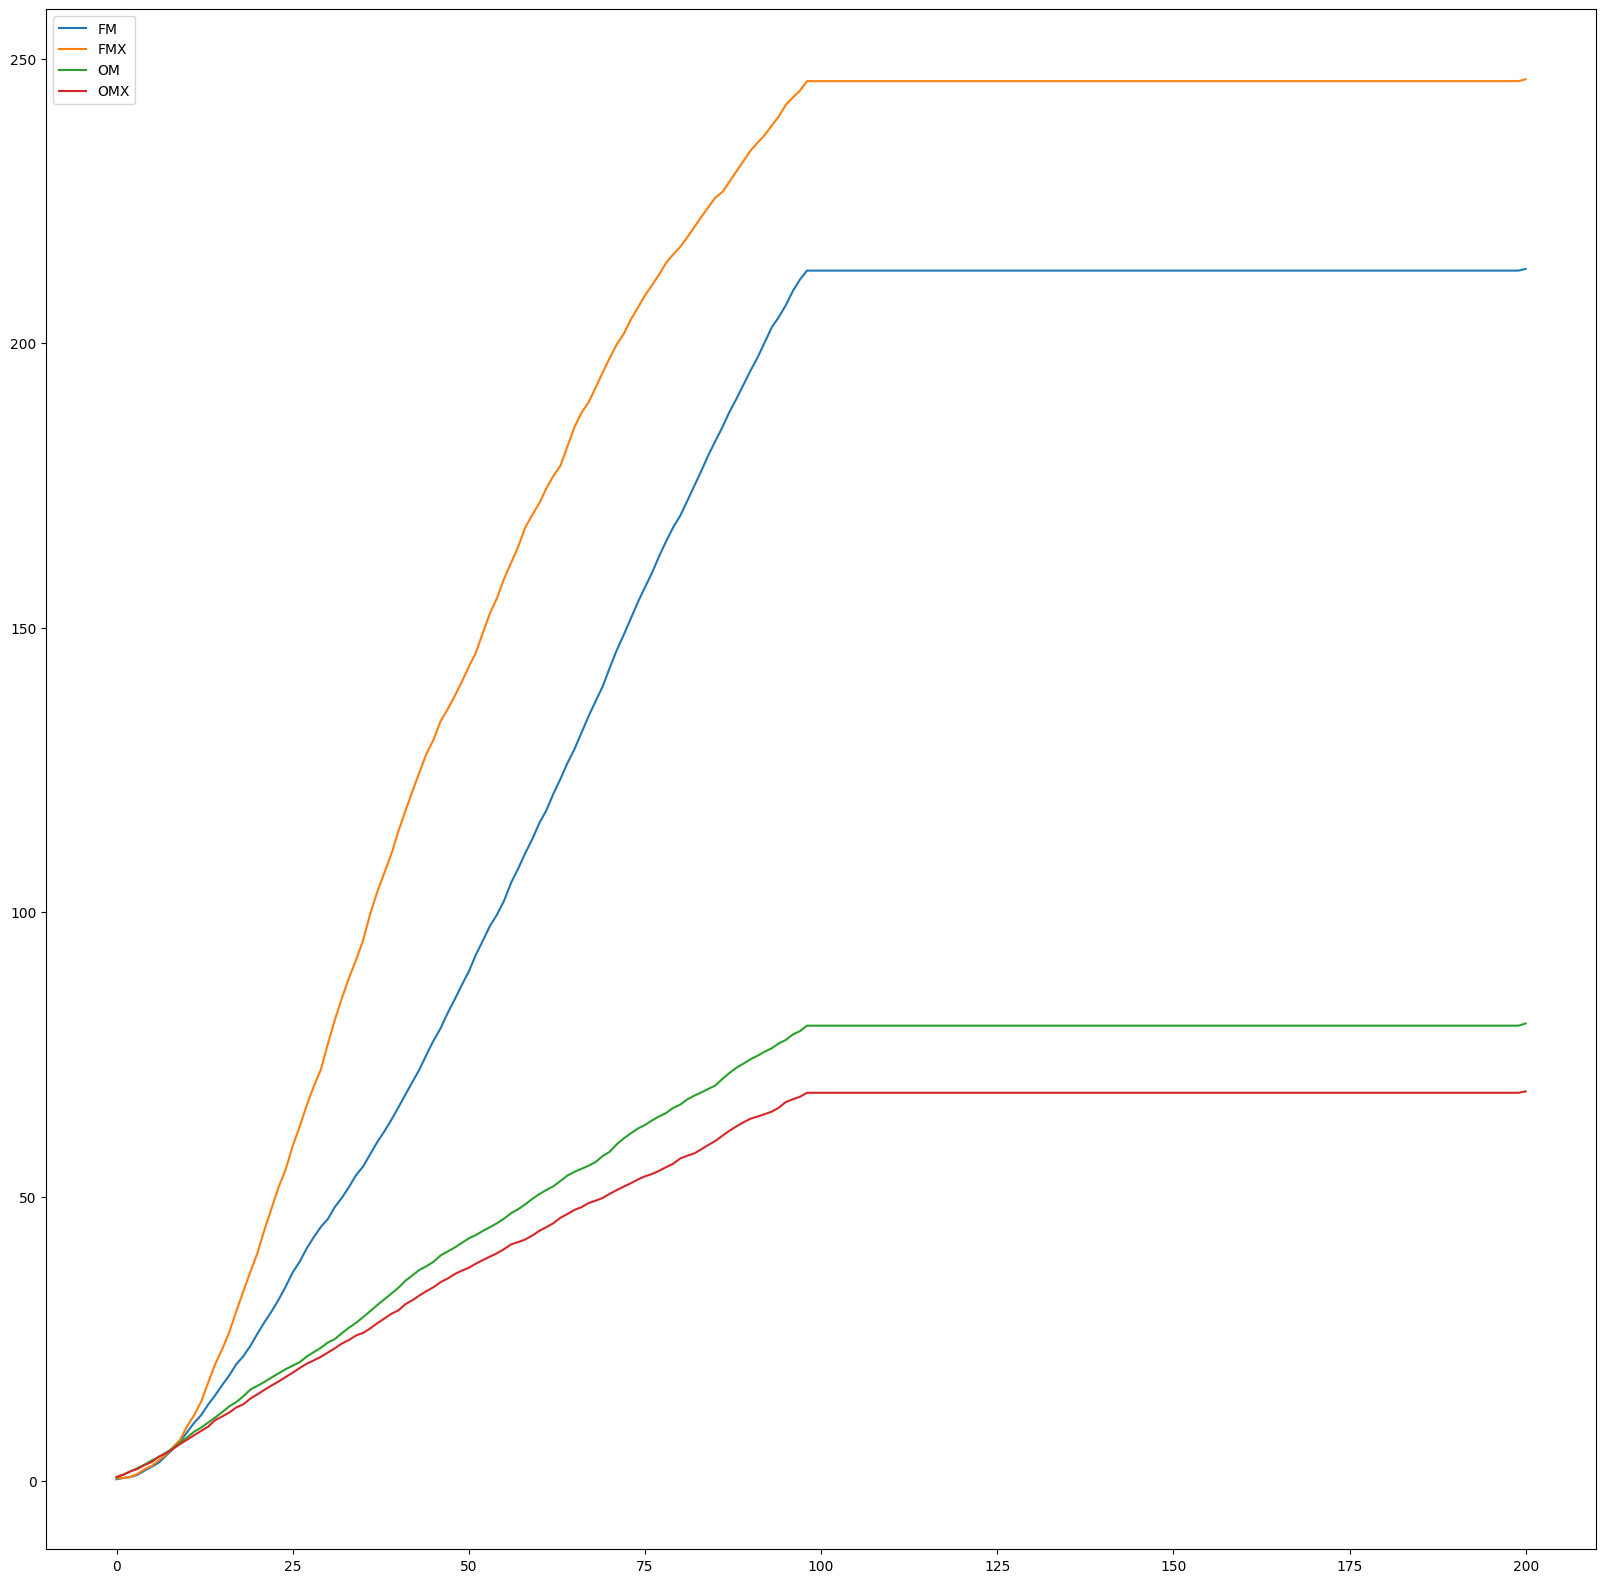

In [ ]:
threshold = -0.2

print("FM")
fm_uniques_good = get_evaluations(df_fm, df_fm['fitness'] < threshold)
print("FMX")
fmx_uniques_good = get_evaluations(df_fmx, df_fmx['fitness'] < threshold)
print("OM")
om_uniques_good = get_evaluations(df_om, df_om['fitness'] < threshold)
print("OMX")
omx_uniques_good = get_evaluations(df_omx, df_omx['fitness'] < threshold)
plt.plot(np.arange(201), np.cumsum(np.average(fm_uniques_good, axis=0), axis=0), label="FM")
plt.plot(np.arange(201), np.cumsum(np.average(fmx_uniques_good, axis=0), axis=0), label="FMX")
plt.plot(np.arange(201), np.cumsum(np.average(om_uniques_good, axis=0), axis=0), label="OM")
plt.plot(np.arange(201), np.cumsum(np.average(omx_uniques_good, axis=0), axis=0), label="OMX")
plt.legend()
plt.show()

FM
Average evaluations per run: 148.8 (30)
FMX
Average evaluations per run: 140.93333333333334 (15)
OM
Average evaluations per run: 52.46153846153846 (26)
OMX
Average evaluations per run: 32.44827586206897 (29)


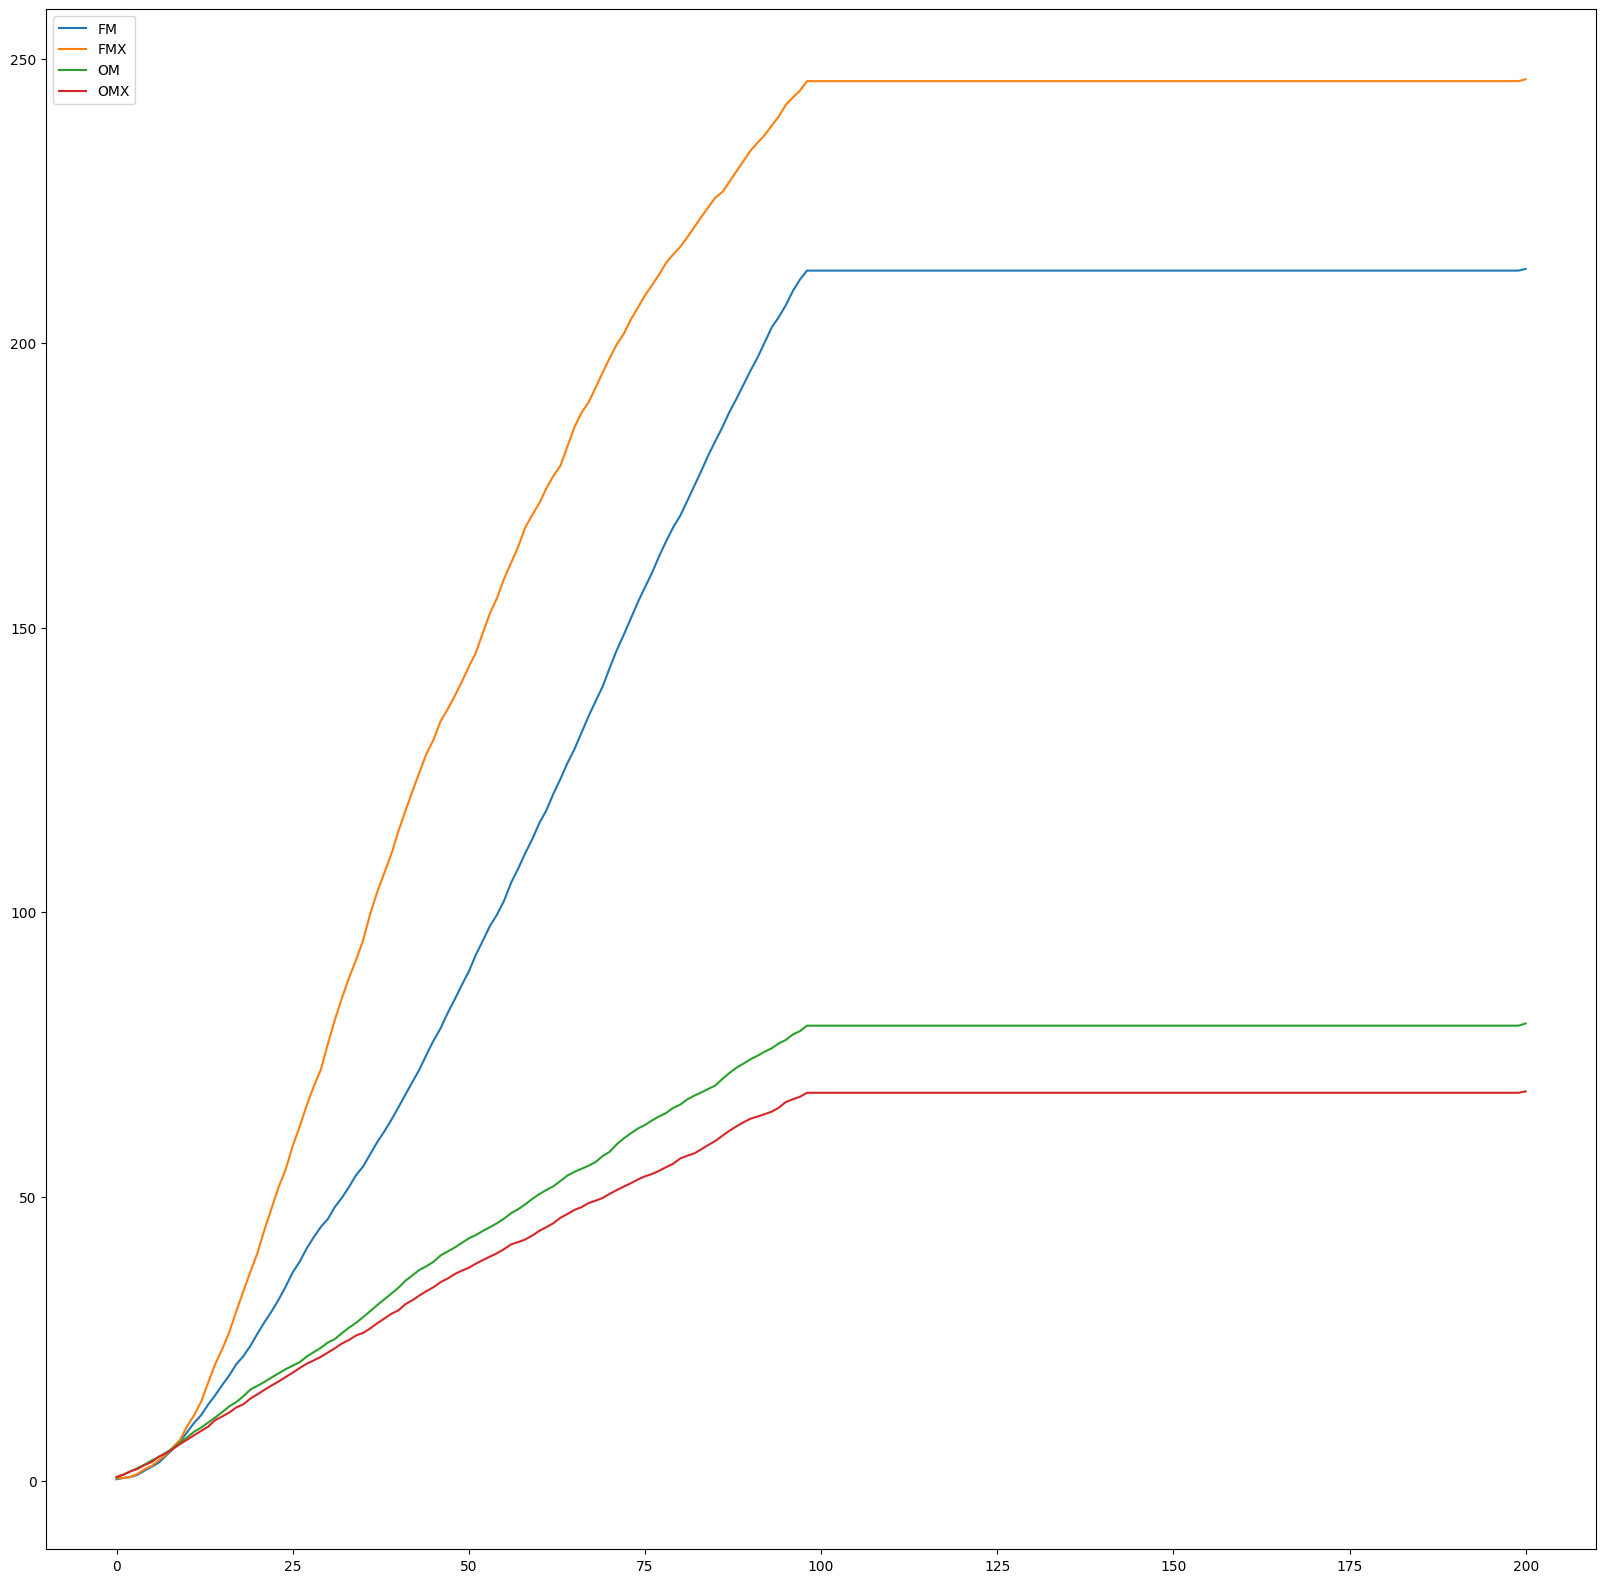

In [ ]:
threshold = -0.6

print("FM")
fm_uniques_best = get_evaluations(df_fm, df_fm['fitness'] < threshold)
print("FMX")
fmx_uniques_best = get_evaluations(df_fmx, df_fmx['fitness'] < threshold)
print("OM")
om_uniques_best = get_evaluations(df_om, df_om['fitness'] < threshold)
print("OMX")
omx_uniques_best = get_evaluations(df_omx, df_omx['fitness'] < threshold)
plt.plot(np.arange(201), np.cumsum(np.average(fm_uniques_good, axis=0), axis=0), label="FM")
plt.plot(np.arange(201), np.cumsum(np.average(fmx_uniques_good, axis=0), axis=0), label="FMX")
plt.plot(np.arange(201), np.cumsum(np.average(om_uniques_good, axis=0), axis=0), label="OM")
plt.plot(np.arange(201), np.cumsum(np.average(omx_uniques_good, axis=0), axis=0), label="OMX")
plt.legend()
plt.show()

### Plot uniques

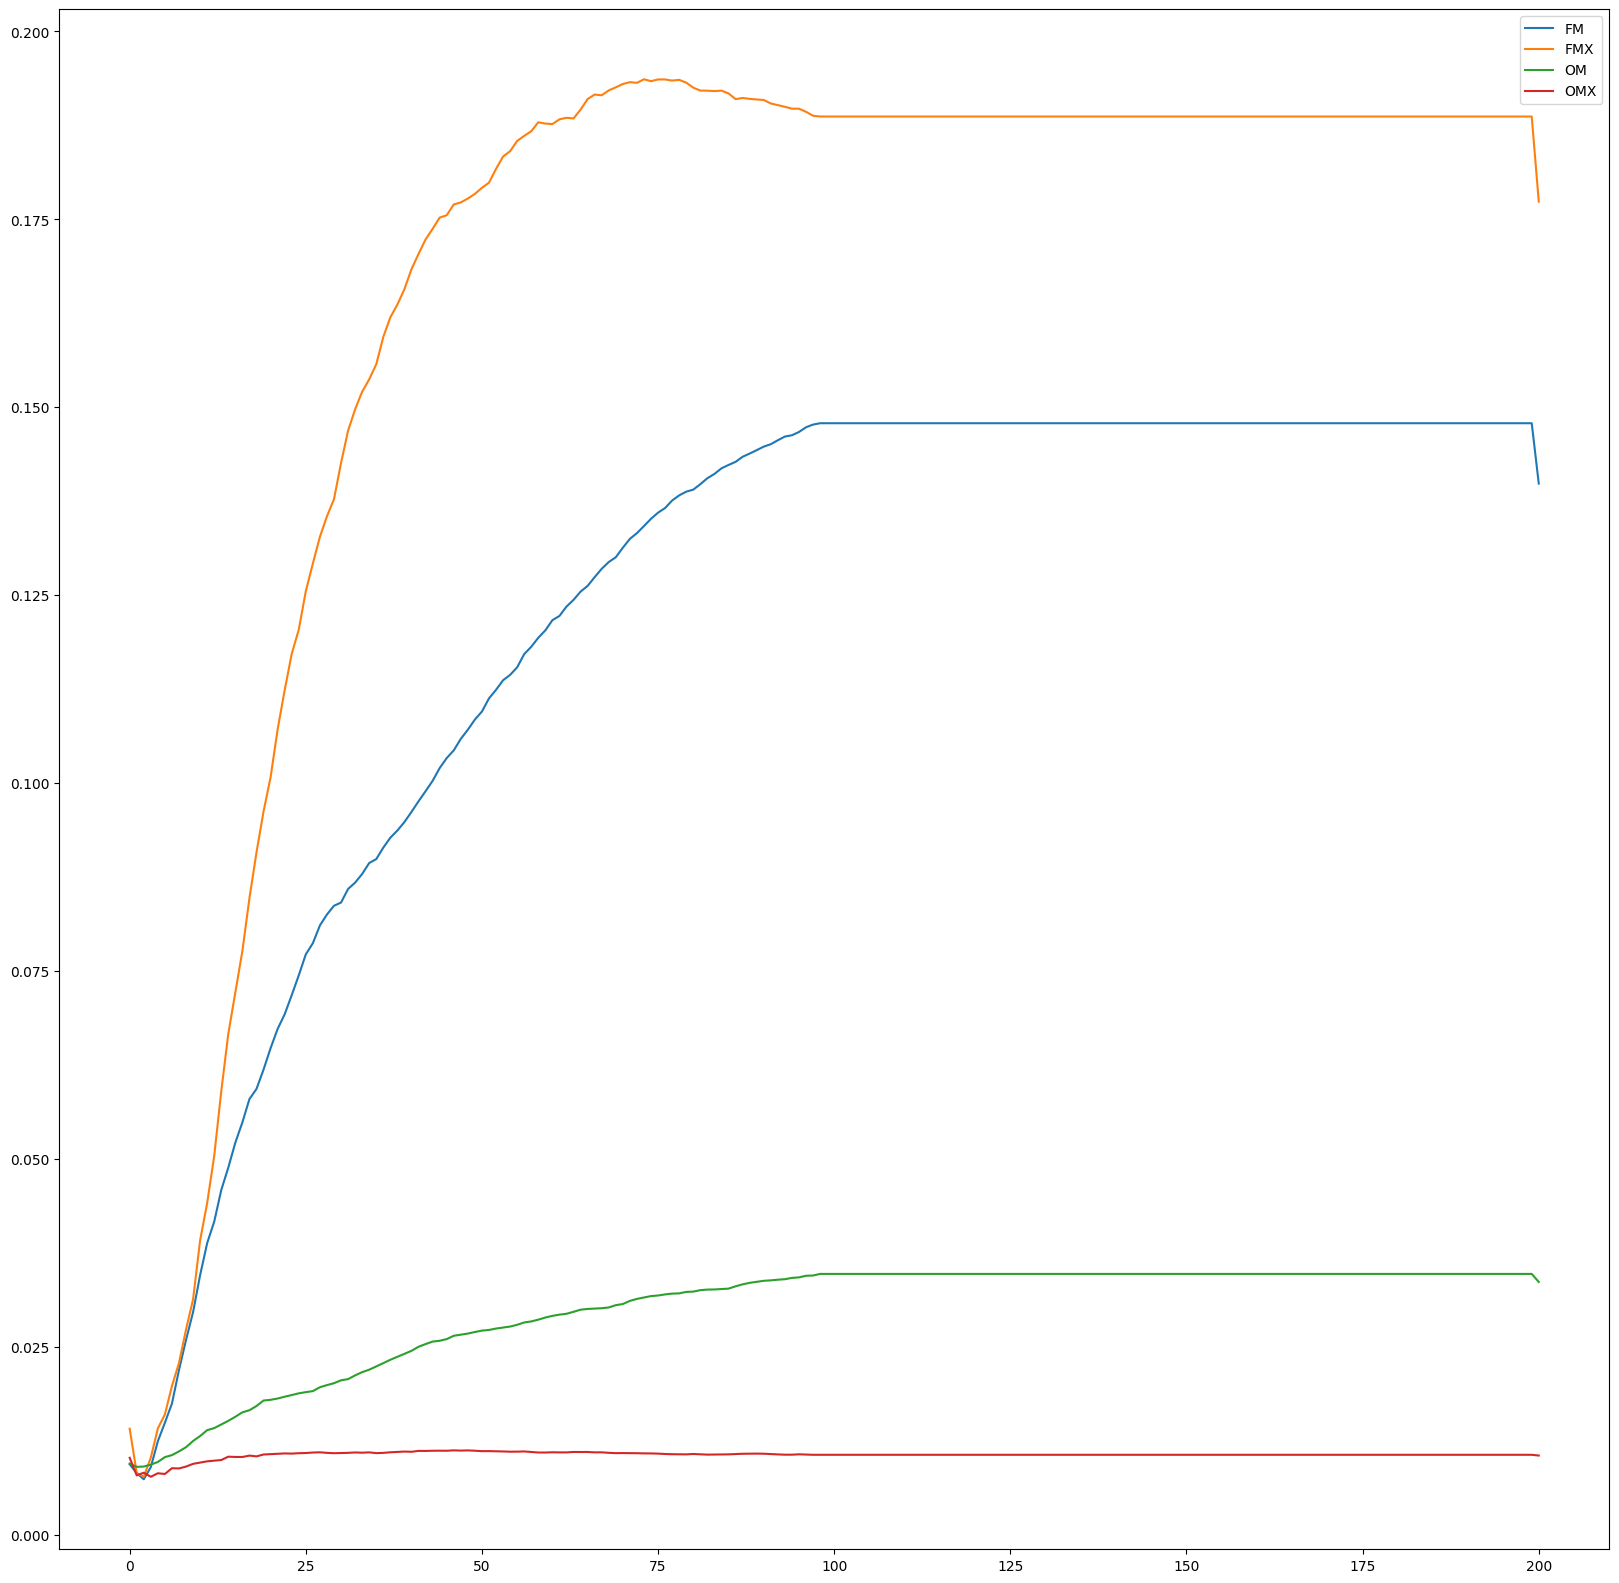

In [ ]:
plt.plot(np.arange(201), np.cumsum(np.average(fm_uniques_good, axis=0), axis=0) /  np.cumsum(np.average(fm_uniques, axis=0), axis=0), label="FM")
plt.plot(np.arange(201), np.cumsum(np.average(fmx_uniques_good, axis=0), axis=0) /  np.cumsum(np.average(fmx_uniques, axis=0), axis=0), label="FMX")
plt.plot(np.arange(201), np.cumsum(np.average(om_uniques_good, axis=0), axis=0) /  np.cumsum(np.average(om_uniques, axis=0), axis=0), label="OM")
plt.plot(np.arange(201), np.cumsum(np.average(omx_uniques_good, axis=0), axis=0) /  np.cumsum(np.average(omx_uniques, axis=0), axis=0), label="OMX")
plt.legend()
plt.show()

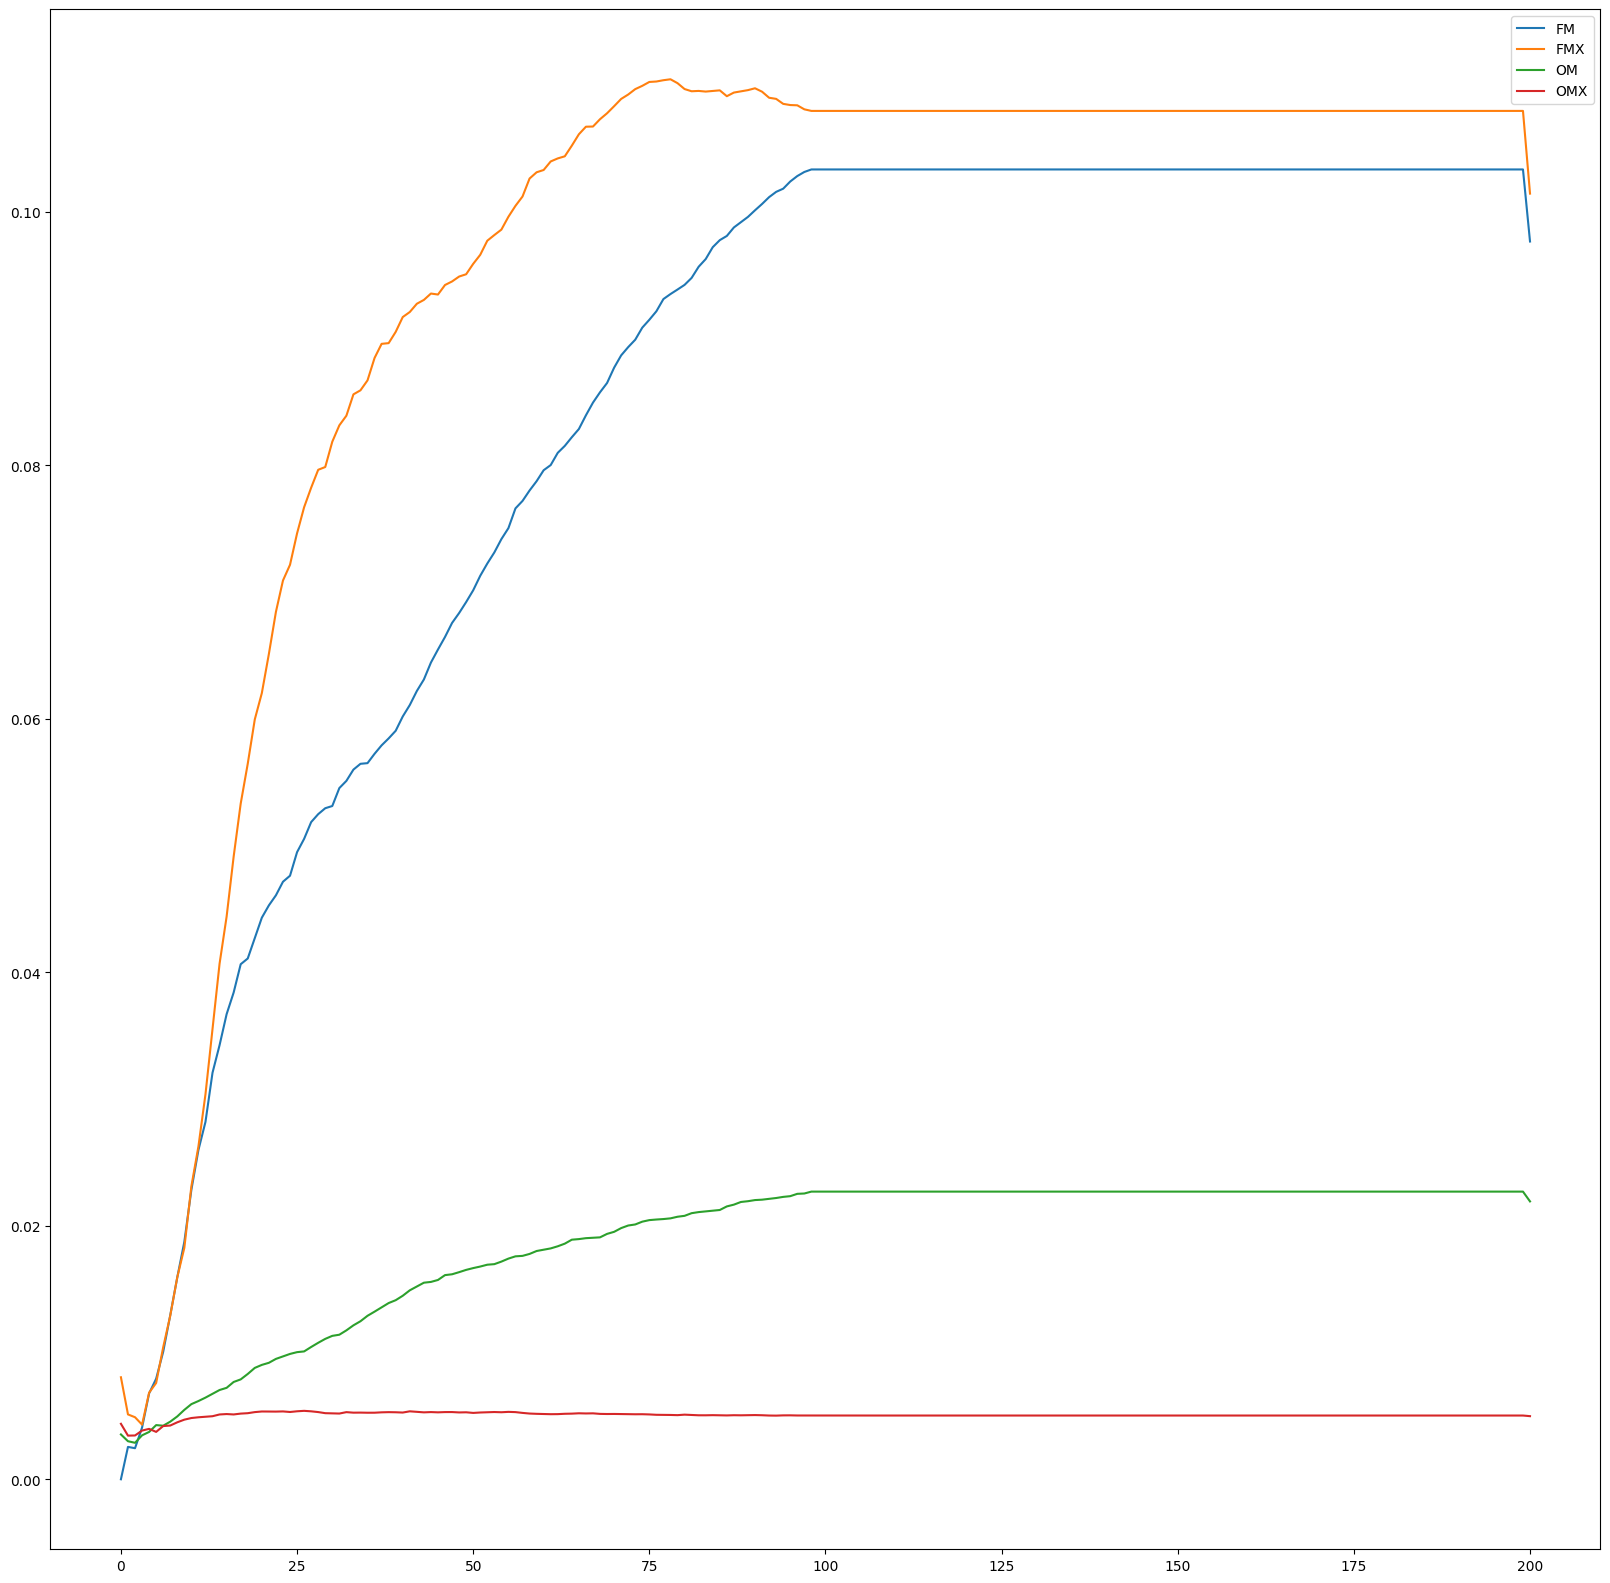

In [ ]:
plt.plot(np.arange(201), np.cumsum(np.average(fm_uniques_best, axis=0), axis=0) /  np.cumsum(np.average(fm_uniques, axis=0), axis=0), label="FM")
plt.plot(np.arange(201), np.cumsum(np.average(fmx_uniques_best, axis=0), axis=0) /  np.cumsum(np.average(fmx_uniques, axis=0), axis=0), label="FMX")
plt.plot(np.arange(201), np.cumsum(np.average(om_uniques_best, axis=0), axis=0) /  np.cumsum(np.average(om_uniques, axis=0), axis=0), label="OM")
plt.plot(np.arange(201), np.cumsum(np.average(omx_uniques_best, axis=0), axis=0) /  np.cumsum(np.average(omx_uniques, axis=0), axis=0), label="OMX")
plt.legend()
plt.show()

### Group by fitness

In [ ]:
df_fm_groupby_run_fitness = df_fm.groupby(['smart_phenotype', 'run']).min()
#for x in df_fm_groupby_run_fitness.index.get_level_values("smart_phenotype").unique():#
#    if len(df_fm_groupby_run_fitness.loc[x]) != 1:
#        print(x, len(df_fm_groupby_run_fitness.loc[x]))
df_fm_groupby_run_fitness = df_fm.drop_duplicates(['smart_phenotype', 'run']).groupby('smart_phenotype').count()
df_fm_groupby_run_fitness[df_fm_groupby_run_fitness["setup"] > 1]
#fit_series = [df_fm[df_fm['smart_phenotype'] == x]['fitness'] for x in df_fm_groupby_run_fitness.index.get_level_values("smart_phenotype")]
def fetch_fitness(x):
    if x.name == 'fitness':
        return df_fm.loc[df_fm['smart_phenotype']]['fitness'].mean()
    else:
        return x

df_fm_groupby_run_fitness.head(5).apply(fetch_fitness, axis=0)
#df_fm_groupby_run_fitness.head(1).apply(lambda x: x['fitness'] = df_fm.loc[df_fm['smart_phenotype'] == x.name], axis=1)

#df_fm_groupby_run_fitness.loc[df_fm_groupby_run_fitness.index.get_level_values("smart_phenotype").unique()]

KeyError: "None of [Index(['divide_no_nan(sqrt(divide_no_nan(add(pow(add(grad, constant(9.25893264e-01)), divide_no_nan(alpha, constant(1.27951705e-01))), pow(alpha, negative(sqrt(divide_no_nan(grad, grad))))), pow(alpha, negative(sqrt(divide_no_nan(grad, grad)))))), constant(9.76737464e-01))',\n       'subtract(grad, pow(constant(1.0), grad))',\n       'sqrt(multiply(negative(divide_no_nan(pow(subtract(negative(grad), grad), subtract(alpha, add(square(beta), multiply(sqrt(square(add(grad, negative(pow(add(grad, grad), divide_no_nan(beta, sigma)))))), negative(alpha))))), pow(grad, constant(1.56514861e-02)))), alpha))',\n       'subtract(square(grad), pow(square(grad), add(divide_no_nan(grad, negative(sqrt(beta))), square(grad))))',\n       'divide_no_nan(grad, pow(add(grad, add(square(divide_no_nan(grad, constant(9.38616893e-01))), pow(divide_no_nan(divide_no_nan(grad, constant(5.55606489e-05)), grad), grad))), add(grad, add(pow(constant(7.12814099e-01), square(add(add(subtract(grad, grad), multiply(grad, subtract(grad, add(grad, grad)))), grad))), add(grad, pow(negative(grad), grad))))))',\n       'pow(subtract(divide_no_nan(add(grad, constant(9.99771521e-01)), add(negative(multiply(add(constant(1.0), constant(9.96851186e-01)), subtract(divide_no_nan(add(add(grad, constant(9.99771521e-01)), multiply(pow(add(grad, constant(9.99771521e-01)), add(constant(1.0), constant(1.05038445e-02))), negative(negative(constant(1.0))))), constant(1.0)), divide_no_nan(add(negative(subtract(constant(7.88036666e-01), constant(3.44451957e-02))), constant(4.24816868e-01)), subtract(constant(7.88036666e-01), constant(3.44451957e-02)))))), add(constant(1.01848815e-04), sqrt(negative(constant(7.52336199e-01)))))), multiply(add(pow(add(constant(1.0), constant(1.0)), multiply(constant(9.94242714e-01), square(constant(2.87185901e-01)))), subtract(constant(7.88036666e-01), constant(3.44451957e-02))), constant(9.99771521e-01))), constant(2.83228820e-02))',\n       'add(grad, sigma)',\n       'subtract(add(beta, grad), constant(9.95290886e-01))',\n       'sqrt(pow(divide_no_nan(square(sigma), constant(4.18766684e-04)), negative(grad)))',\n       'add(grad, grad)',\n       ...\n       'divide_no_nan(grad, subtract(grad, add(grad, constant(9.71677118e-01))))',\n       'divide_no_nan(grad, subtract(grad, add(subtract(grad, pow(sqrt(beta), grad)), square(grad))))',\n       'divide_no_nan(grad, constant(6.69753570e-01))',\n       'divide_no_nan(grad, subtract(grad, add(pow(grad, pow(sqrt(constant(9.71677118e-01)), grad)), square(grad))))',\n       'divide_no_nan(divide_no_nan(grad, grad), subtract(grad, add(subtract(grad, pow(sqrt(constant(9.71677118e-01)), grad)), square(grad))))',\n       'divide_no_nan(grad, subtract(grad, add(subtract(grad, pow(sqrt(beta), grad)), square(grad))))',\n       'divide_no_nan(grad, subtract(grad, add(subtract(pow(sqrt(square(grad)), constant(9.71677118e-01)), sqrt(grad)), add(grad, negative(grad)))))',\n       'divide_no_nan(grad, subtract(add(subtract(pow(grad, sqrt(grad)), alpha), grad), square(grad)))',\n       'grad',\n       'divide_no_nan(constant(9.95290886e-01), subtract(grad, add(subtract(grad, pow(sqrt(constant(9.71677118e-01)), grad)), square(grad))))'],\n      dtype='object', length=299500)] are in the [index]"

In [ ]:
df = df_fm
print(np.average(df, axis=0).head(5))
print(df.apply(np.average, axis=1).head(5))